In [1]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import seaborn as sns                                  # Make the plots nicer to look at
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy.signal import find_peaks
import glob
import os

In [2]:
sys.path.append('External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# In case you want to load function from a jupyter notebook from the current working directory, you can use the function below:
#   from ipynb.fs.full.ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def line(x,a,b):
    """Just a line"""
    return a*x+b

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def exp_pdf(x, a, V0, s0):
    """Exponential"""
    return 0.5 * a * x**2 + V0 * x + s0

In [4]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

In [18]:
def cal_avg_error(df):
    list = []
    df = df.append(pd.Series(0, index=df.columns), ignore_index=True) #adds row

    for i in range(int(len(df.T)/2)):
        # Weighted Average
        df.iloc[-1, i*2], df.iloc[-1, i*2+1] = w_mean(df.iloc[:, i*2], df.iloc[:, i*2+1])
    
        #Error (needs updating)
        #df.iloc[-1, i*2+1] = df.iloc[:, i*2+1].mean()
    
    return df

In [22]:
def w_mean(dat,err):
    weight = 0
    for i in err:
        if i == 0:
            break
        weight += (1/i)**2

    mean_weighted = 0
    for i in range(len(dat)):
        mean_weighted += (dat[i]*(1/err[i])**2)/weight

    err_weighted = np.sqrt(1/weight)
    return mean_weighted, err_weighted

In [6]:
Pen = pd.read_csv (r'CSV/Pendul.csv', sep=";")

Pen_data1 = pd.read_csv (r'Data/Pendul/Malthe1.dat', sep='\t')
Pen_data2 = pd.read_csv (r'Data/Pendul/Mads1.dat', sep='\t')
Pen_data3 = pd.read_csv (r'Data/Pendul/Niels1.dat', sep='\t')
Pen_data4 = pd.read_csv (r'Data/Pendul/Emilie1.dat', sep='\t')

Pen_data = []
Pen_data.append(Pen_data1)
Pen_data.append(Pen_data2)
Pen_data.append(Pen_data3)
Pen_data.append(Pen_data4)

In [7]:
Pen

,Snorlængde_mm,Snorlængde_mm_error,Lod_mm,Lod_mm_error,Lod_med_krog_mm,Lod_med_krog_mm_error,Krog_mm,Mass_g
0,1988.8,0.4,36.550,0.02,50.120,0.06,13.570,200
1,1988.5,0.5,36.450,0.05,50.149,0.05,13.699,200
2,1988.1,0.2,36.510,0.02,50.451,0.02,13.941,200
3,1987.8,0.6,36.395,0.07,50.300,0.07,13.910,200


In [23]:
cal_avg_error(Pen)[-1:]

<ipython-input-22-5c1d55cdf0ed>:10: RuntimeWarning: divide by zero encountered in double_scalars
  mean_weighted += (dat[i]*(1/err[i])**2)/weight
<ipython-input-22-5c1d55cdf0ed>:10: RuntimeWarning: invalid value encountered in double_scalars
  mean_weighted += (dat[i]*(1/err[i])**2)/weight
<ipython-input-22-5c1d55cdf0ed>:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  mean_weighted += (dat[i]*(1/err[i])**2)/weight


,Snorlængde_mm,Snorlængde_mm_error,Lod_mm,Lod_mm_error,Lod_med_krog_mm,Lod_med_krog_mm_error,Krog_mm,Mass_g
4,NaN,0.162162,NaN,0.013358,NaN,0.017196,NaN,100.0


Først bestemmer vi L, pendul længden.

In [9]:
#Sum of Weighted Average for pendulum
x = cal_avg_error(Pen)[-1:]
L_mm = x.iloc[0,0] + x.iloc[0,2]*0.5 + (x.iloc[0,4] - x.iloc[0,2])
L_mm

2020.2749999999999

9805.437740538318


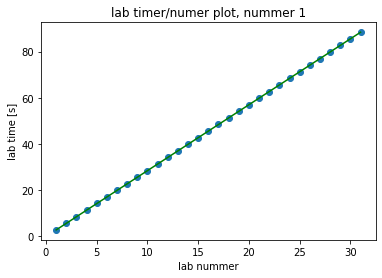

9802.655699524963


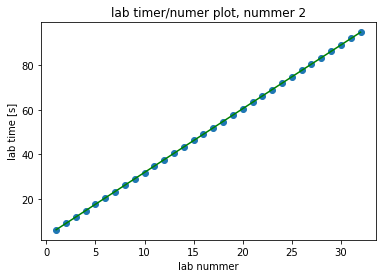

9799.544355259237


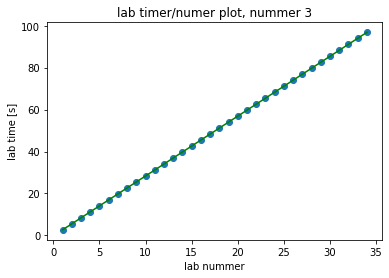

9784.564253407221


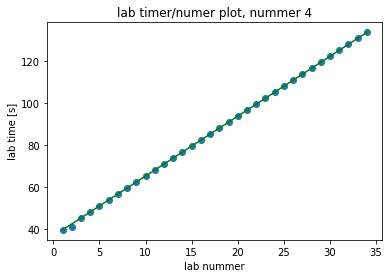

[[2.8520137826081875, -0.02363702899497966],
 [2.8524184615380768, 3.4221596923011397],
 [2.8528712454214222, -0.1760758852229749],
 [2.8550542735043662, 36.553342877495126]]

In [10]:
minuit_line_val = []
for i in range(len(Pen_data)):
    Minuit.print_level = i    # Print result of fits (generally - can also be moved down to each fit instance)
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2]
    
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, x, y)

    minuit_chi2 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    
    print(L_mm.mean()*(2*np.pi/minuit_chi2.values[:][0])**2)
    
    minuit_line_val.append(minuit_chi2.values[:])
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot, nummer {i+1}')

    plt.scatter(Pen_data[i].Lab,Pen_data[i].Time)
    ax.plot(Pen_data[i].Lab, line(Pen_data[i].Lab, *minuit_chi2.values[:]), '-g', label='Unbinned LLH fit model result') 
    plt.show()

minuit_line_val

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 184.1                      │              Nfcn = 74               │
│ EDM = 2.08e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

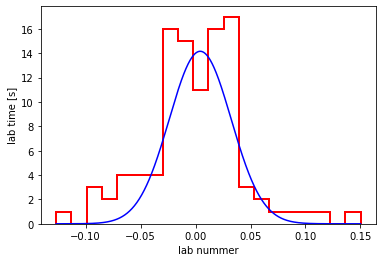

In [11]:
Nbins = 20
deltay_all = []
minuit_gauss_val = []
for i in range(len(Pen_data)):
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2]
    deltay = y - line(x, minuit_line_val[i][0],minuit_line_val[i][1])
    deltay_all.extend(deltay)
    
counts, bin_edges = np.histogram(deltay_all, bins=Nbins, range=(min(deltay_all), max(deltay_all)))

x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
#sy = np.sqrt(counts[counts>0])

# Defining Chi2 calculation:
chi2fit = Chi2Regression(gauss_pdf, x, y)

minuit_chi2_error = Minuit(chi2fit, mu=0, sigma=1)
minuit_chi2_error.errordef = 1.0     # This is the definition for ChiSqaure fits
print(minuit_chi2_error.migrad())
    
minuit_gauss_val.append(minuit_chi2_error.values[:])
    
    
    
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('lab time [s]')
ax.set_xlabel('lab nummer')
#ax.set_title(f'lab timer/numer plot, nummer {i+1}')


    
hist = ax.hist(deltay_all, bins=Nbins, range=(min(deltay_all), max(deltay_all)), histtype='step', linewidth=2, color='red', label='Data, normal histogram')
    
x_axis = np.linspace(min(deltay_all), max(deltay_all), 1000)
ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2_error.values[:]), '-b', label='Chi2 fit model result') 
    
plt.show()

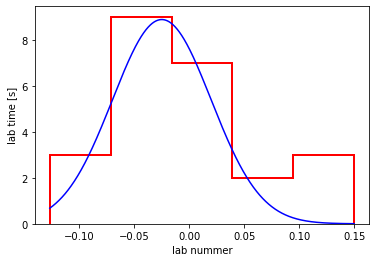

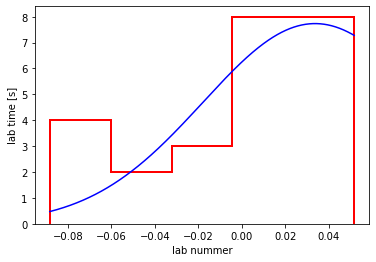

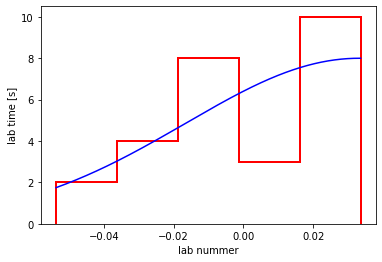

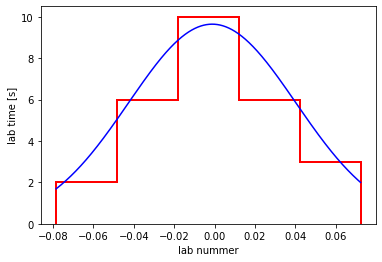

In [12]:
Nbins = 5
deltay_all = []
minuit_gauss_val = []
for i in range(len(Pen_data)):
    Minuit.print_level = i
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2]
    deltay = y - line(x, minuit_line_val[i][0],minuit_line_val[i][1])
    #deltay_all.extend(deltay)
    
    counts, bin_edges = np.histogram(deltay, bins=Nbins, range=(min(deltay), max(deltay)))

    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    #sy = np.sqrt(counts[counts>0])

    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(gauss_pdf, x, y)

    minuit_chi2_error = Minuit(chi2fit, mu=0, sigma=0.1)
    minuit_chi2_error.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2_error.migrad()
    
    minuit_gauss_val.append(minuit_chi2_error.values[:])
    
    
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    #ax.set_title(f'lab timer/numer plot, nummer {i+1}')


    
    hist = ax.hist(deltay, bins=Nbins, range=(min(deltay), max(deltay)), histtype='step', linewidth=2, color='red', label='Data, normal histogram')
    
    x_axis = np.linspace(min(deltay), max(deltay), 1000)
    ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2_error.values[:]), '-b', label='Chi2 fit model result') 
    
    plt.show()

In [13]:
minuit_chi2_error.values[:][1]

0.041383696620405065

9805.437740535344


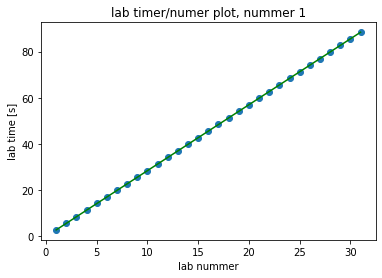

9802.655699521085


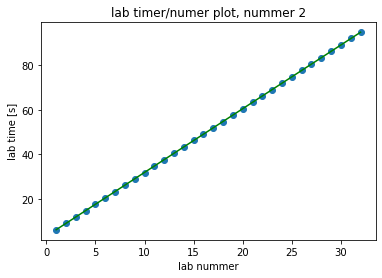

9799.544355261372


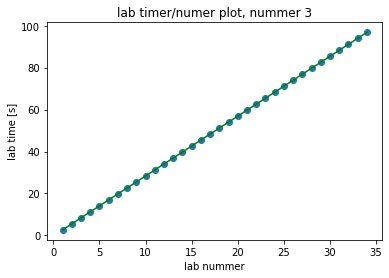

9784.564253408573


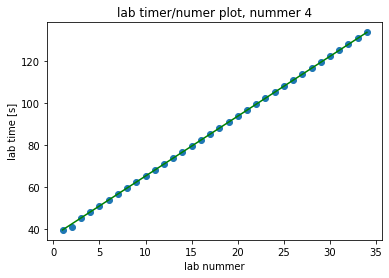

[[2.8520137826086196, -0.02363702898679776],
 [2.8524184615386408, 3.4221596923106397],
 [2.852871245421112, -0.17607588522793804],
 [2.8550542735041695, 36.5533428774909]]

In [16]:
minuit_line_val = []
for i in range(len(Pen_data)):
    Minuit.print_level = i    # Print result of fits (generally - can also be moved down to each fit instance)
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2]
    sy = minuit_chi2_error.values[:][1]
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    print(L_mm.mean()*(2*np.pi/minuit_chi2.values[:][0])**2)
    
    minuit_line_val.append(minuit_chi2.values[:])
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot, nummer {i+1}')

    plt.scatter(Pen_data[i].Lab,Pen_data[i].Time)
    ax.plot(Pen_data[i].Lab, line(Pen_data[i].Lab, *minuit_chi2.values[:]), '-g', label='Unbinned LLH fit model result') 
    plt.show()

minuit_line_val